In [1]:
import pandas as pd
import random
import numpy as np
import string
import re
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import word_tokenize
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from sklearn.ensemble import RandomForestClassifier
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
tweets = pd.read_csv('/content/drive/MyDrive/sample_dataset/tweet_aug.csv')
tweets

,Unnamed: 0,sentimen,tweet
0,0,negatif,kata prabowo indonesia tidak harga bangsa asin...
1,1,negatif,kata prabowo indonesia tidak harga bangsa asin...
2,2,netral,batu langka tasbih jokowi hadiah habib luthfi ...
3,3,netral,batu langka rosario jokowi hadiah habib luthfi...
4,4,netral,era jokowi ekonomi indonesia makin baik maju m...
...,...,...,...
3625,3625,netral,bangun bangsa dukung ekonomi negara sama bapak...
3626,3626,netral,bantu maju ekonomi bangsa sama bapak jokowi yuk
3627,3627,netral,bantu kedepan ekonomi bangsa sama bapak jokowi...
3628,3628,netral,bapak jokowi ubah cara pandang ekonomi kini se...


In [3]:
del tweets[tweets.columns[0]]

In [4]:
tweets

,sentimen,tweet
0,negatif,kata prabowo indonesia tidak harga bangsa asin...
1,negatif,kata prabowo indonesia tidak harga bangsa asin...
2,netral,batu langka tasbih jokowi hadiah habib luthfi ...
3,netral,batu langka rosario jokowi hadiah habib luthfi...
4,netral,era jokowi ekonomi indonesia makin baik maju m...
...,...,...
3625,netral,bangun bangsa dukung ekonomi negara sama bapak...
3626,netral,bantu maju ekonomi bangsa sama bapak jokowi yuk
3627,netral,bantu kedepan ekonomi bangsa sama bapak jokowi...
3628,netral,bapak jokowi ubah cara pandang ekonomi kini se...


In [5]:
tweets['sentimen'].value_counts()

positif    1224
netral     1214
negatif    1192
Name: sentimen, dtype: int64

In [6]:
mapping = {
    "negatif": 0,
    "netral": 1,
    "positif": 2,
}

tweets['sentimen'] = [mapping[label] for label in tweets['sentimen']]
tweets

,sentimen,tweet
0,0,kata prabowo indonesia tidak harga bangsa asin...
1,0,kata prabowo indonesia tidak harga bangsa asin...
2,1,batu langka tasbih jokowi hadiah habib luthfi ...
3,1,batu langka rosario jokowi hadiah habib luthfi...
4,1,era jokowi ekonomi indonesia makin baik maju m...
...,...,...
3625,1,bangun bangsa dukung ekonomi negara sama bapak...
3626,1,bantu maju ekonomi bangsa sama bapak jokowi yuk
3627,1,bantu kedepan ekonomi bangsa sama bapak jokowi...
3628,1,bapak jokowi ubah cara pandang ekonomi kini se...


# Split Data

In [7]:
tweets['tweet'] = tweets['tweet'].astype(str)
tweets['tweet'] = tweets['tweet'].fillna('')

In [8]:
features = tweets['tweet']
target = tweets['sentimen']

In [9]:
X = features
Y = target
# display(X)
# display(Y)

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [11]:
train_tweet, test_tweet, train_sentimen, test_sentimen = train_test_split(tweets['tweet'].to_numpy(), tweets['sentimen'].to_numpy(), test_size=0.2, random_state=0)

In [12]:
round(sum([len(i.split()) for i in train_tweet])/len(train_tweet))

19

In [13]:
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 19 # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer = TextVectorization(
    max_tokens=max_vocab_length,
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    output_mode="int",
    output_sequence_length=max_length)

In [14]:
text_vectorizer

In [15]:
text_vectorizer.adapt(X_train.to_numpy())

In [16]:
sample_setence = X_train[0]
text_vectorizer([sample_setence])

<tf.Tensor: shape=(1, 19), dtype=int64, numpy=
array([[  41,    4,   10,    5,    8,   66,  652,  407,  336,   33,  200,
          26,   54, 1965,    0,    0,    0,    0,    0]])>

In [17]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:10] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-10:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}")
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 5658
Top 5 most common words: ['', '[UNK]', 'ekonomi', 'jokowi', 'prabowo', 'tidak', 'bapak', 'gaji', 'harga', 'salah']
Bottom 5 least common words: ['absolut', 'abshar', 'absah', 'abg', 'abdul', 'abdalla', 'abah', 'abadi', 'aaamiin', 'aa']


# Create Embedding

In [18]:
tf.random.set_seed(42)

embedding = layers.Embedding(
    input_dim=max_vocab_length,
    output_dim=64,
    embeddings_initializer="uniform",
    input_length=max_length,
    name="embedding_1")

embedding

In [19]:
# Get a random sentence from training set
random_sentence = random.choice(X_train)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")
# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
coblos prabowo sandi arti pahala jauh golongan gaji prabowo sandi sumbang anakyatim orang miskin benar tusuk pahala alir tahun keji brutal prabowo sandi      

Embedded version:


<tf.Tensor: shape=(1, 19, 64), dtype=float32, numpy=
array([[[-0.04617161,  0.03632874,  0.02736867, ...,  0.03990617,
         -0.03392603,  0.00766517],
        [-0.04754906, -0.0264964 , -0.03014324, ..., -0.04439031,
         -0.01604271,  0.03253459],
        [ 0.04875429, -0.0437562 ,  0.01455515, ...,  0.02776047,
          0.00646211,  0.00979732],
        ...,
        [ 0.04436168, -0.00359385,  0.03276728, ...,  0.03387728,
         -0.03928808, -0.0042716 ],
        [ 0.03372201, -0.03431835,  0.04571754, ...,  0.01330629,
         -0.01434876,  0.04159838],
        [ 0.01977141, -0.04815641,  0.00363383, ..., -0.04686421,
          0.01726862, -0.00228846]]], dtype=float32)>

In [20]:
def calculate_results(y_true, y_pred):

  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

# Model 1

In [21]:
def model1():

  inputs = layers.Input(shape=(1,), dtype="string")
  x = text_vectorizer(inputs)
  layer = embedding(x)
  layer = layers.LSTM(32)(layer)
  layer = layers.Dense(3, name='out_layer')(layer)
  layer = layers.Activation('softmax')(layer)
  model = tf.keras.Model(inputs=inputs, outputs=layer, name="model_1_LSTM")
  return model

In [22]:
lstm1 = model1()
lstm1.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
lstm1.summary()

Model: "model_1_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 19)                0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, 19, 64)            640000    
                                                                 
 lstm (LSTM)                 (None, 32)                12416     
                                                                 
 out_layer (Dense)           (None, 3)                 99        
                                                                 
 activation (Activation)     (None, 3)                 0         
                                                      

In [23]:
lstm1_history = lstm1.fit(X_train, np.float32(Y_train),
                          epochs=20,
                          batch_size=256,
                          validation_data=(X_test, np.float32(Y_test)),)

Epoch 1/20
12/12 [==============================] - 9s 333ms/step - loss: 1.0896 - accuracy: 0.4308 - val_loss: 1.0750 - val_accuracy: 0.4669
Epoch 2/20
12/12 [==============================] - 1s 97ms/step - loss: 1.0486 - accuracy: 0.5740 - val_loss: 1.0258 - val_accuracy: 0.5427
Epoch 3/20
12/12 [==============================] - 1s 98ms/step - loss: 0.9612 - accuracy: 0.6581 - val_loss: 0.9495 - val_accuracy: 0.6639
Epoch 4/20
12/12 [==============================] - 1s 109ms/step - loss: 0.7924 - accuracy: 0.7369 - val_loss: 0.8262 - val_accuracy: 0.6915
Epoch 5/20
12/12 [==============================] - 1s 93ms/step - loss: 0.5541 - accuracy: 0.8158 - val_loss: 0.7325 - val_accuracy: 0.7052
Epoch 6/20
12/12 [==============================] - 1s 97ms/step - loss: 0.3402 - accuracy: 0.8864 - val_loss: 0.6461 - val_accuracy: 0.7700
Epoch 7/20
12/12 [==============================] - 1s 82ms/step - loss: 0.1971 - accuracy: 0.9452 - val_loss: 0.5790 - val_accuracy: 0.8182
Epoch 8/20


In [24]:
test_sentimen

array([1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 2, 1, 2,
       0, 0, 2, 0, 0, 2, 0, 2, 2, 2, 1, 1, 0, 0, 2, 0, 2, 0, 2, 1, 1, 2,
       0, 1, 1, 0, 1, 2, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 2, 2, 2, 1, 1, 0,
       1, 0, 1, 1, 2, 2, 0, 2, 1, 1, 0, 1, 2, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       2, 0, 2, 0, 0, 2, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 2, 0, 1,
       0, 2, 0, 1, 0, 2, 1, 0, 1, 2, 2, 0, 1, 2, 1, 1, 1, 0, 2, 1, 0, 2,
       0, 2, 2, 2, 0, 0, 2, 2, 0, 0, 2, 2, 0, 1, 2, 2, 0, 1, 2, 0, 1, 2,
       0, 0, 0, 1, 0, 1, 2, 2, 1, 1, 2, 1, 1, 0, 2, 1, 2, 1, 2, 2, 0, 1,
       0, 1, 2, 0, 2, 1, 2, 2, 2, 1, 2, 0, 2, 1, 1, 1, 1, 2, 0, 2, 1, 0,
       1, 0, 2, 2, 0, 2, 1, 0, 2, 2, 1, 1, 1, 0, 1, 1, 1, 2, 2, 2, 1, 2,
       2, 2, 0, 2, 1, 0, 2, 0, 2, 1, 1, 0, 2, 1, 2, 1, 2, 1, 0, 0, 2, 0,
       2, 1, 1, 0, 1, 0, 1, 1, 0, 0, 2, 0, 2, 1, 0, 0, 0, 2, 1, 2, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 2, 2, 0, 0, 0, 0, 1, 2, 0, 2, 0, 0, 1, 0, 1,
       0, 2, 2, 2, 1, 0, 0, 2, 0, 2, 1, 0, 0, 2, 0,

In [25]:
# Make predictions on the validation dataset
model_1_pred_probs = lstm1.predict(test_tweet)
display(model_1_pred_probs.shape, model_1_pred_probs[:10]) # view the first 10

model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds = np.argmax(model_1_preds, axis=1)

# Calculate LSTM model results
model_1_results = calculate_results(y_true=test_sentimen,
                                    y_pred=model_1_preds)
display(model_1_results)

display(tf.squeeze(tf.round(lstm1.predict(np.array(['Pak @sandiuno dan pak @prabowo Gajinya kirim ke saya sj'])))).numpy())

23/23 [==============================] - 1s 5ms/step


(726, 3)

array([[2.6423810e-02, 9.3050408e-01, 4.3072116e-02],
       [1.4091176e-02, 9.5685852e-01, 2.9050209e-02],
       [9.9642009e-01, 6.9112371e-04, 2.8888972e-03],
       [2.6220928e-03, 9.9437517e-01, 3.0027283e-03],
       [1.3284007e-03, 9.9705195e-01, 1.6196634e-03],
       [1.5001411e-03, 7.6020480e-04, 9.9773967e-01],
       [1.7171709e-03, 9.9592394e-01, 2.3587549e-03],
       [1.1706824e-03, 9.9742967e-01, 1.3996396e-03],
       [2.9472776e-03, 3.0762269e-03, 9.9397659e-01],
       [5.0971117e-03, 9.8914284e-01, 5.7600555e-03]], dtype=float32)

{'accuracy': 84.15977961432507,
 'precision': 0.8448174643289357,
 'recall': 0.8415977961432507,
 'f1': 0.8421067283164502}

1/1 [==============================] - 0s 24ms/step


array([0., 0., 0.], dtype=float32)

In [26]:
predicted_sentiment = []

for idx in range(len(test_tweet)):
  predicted = tf.squeeze(tf.round(lstm1.predict(np.array([test_tweet[idx]])))).numpy()
  predicted_sentiment.append(predicted)

1/1 [==============================] - 0s 32ms/step


In [27]:
predicted_sentiment

[array([0., 1., 0.], dtype=float32),
 array([0., 1., 0.], dtype=float32),
 array([1., 0., 0.], dtype=float32),
 array([0., 1., 0.], dtype=float32),
 array([0., 1., 0.], dtype=float32),
 array([0., 0., 1.], dtype=float32),
 array([0., 1., 0.], dtype=float32),
 array([0., 1., 0.], dtype=float32),
 array([0., 0., 1.], dtype=float32),
 array([0., 1., 0.], dtype=float32),
 array([0., 1., 0.], dtype=float32),
 array([1., 0., 0.], dtype=float32),
 array([0., 1., 0.], dtype=float32),
 array([0., 1., 0.], dtype=float32),
 array([0., 1., 0.], dtype=float32),
 array([0., 0., 1.], dtype=float32),
 array([0., 0., 1.], dtype=float32),
 array([0., 1., 0.], dtype=float32),
 array([0., 0., 1.], dtype=float32),
 array([0., 0., 1.], dtype=float32),
 array([0., 1., 0.], dtype=float32),
 array([0., 0., 1.], dtype=float32),
 array([0., 0., 1.], dtype=float32),
 array([1., 0., 0.], dtype=float32),
 array([0., 0., 1.], dtype=float32),
 array([1., 0., 0.], dtype=float32),
 array([0., 0., 1.], dtype=float32),
 

In [28]:
predicted_dataframe = pd.DataFrame(columns=['sentimen', 'predicted_sentimen', 'tweet'])

In [29]:
predicted_dataframe['sentimen'] = test_sentimen
predicted_dataframe['predicted_sentimen'] = [np.argmax(array) for array in predicted_sentiment]
predicted_dataframe['tweet'] = test_tweet

display(predicted_dataframe)

,sentimen,predicted_sentimen,tweet
0,1,1,mau tanya impact buat negara kek gimana kalo g...
1,1,1,jokowi raja salman sepakat tingkat kerja sama ...
2,0,0,kala tax amnesty kemarin prabowo sama sandiaga...
3,1,1,gimana nih apa gaji tidak jokowi prabowo
4,1,1,beranganangan gaji dokter binatang minimal jut...
...,...,...,...
721,0,0,nyerocos gurubesar sumitro joyohadikusumo ekon...
722,1,1,asosiasi usaha bumiputera nusantara se indones...
723,0,0,tidak masuk otak lu bapak jokowi nanya ekonomi...
724,0,0,eh abang beda startup monetizing hobi monetize...


# Model 2

In [30]:
def model2():

  inputs = layers.Input(shape=(1,), dtype="string")
  x = text_vectorizer(inputs)
  layer = embedding(x)
  layer = layers.LSTM(64)(layer)
  layer = layers.Dense(256, name='FC1')(layer)
  layer = layers.Activation('relu')(layer)
  layer = layers.Dropout(0.5)(layer)
  layer = layers.Dense(3, name='out_layer')(layer)
  layer = layers.Activation('softmax')(layer)
  model = tf.keras.Model(inputs=inputs, outputs=layer)
  return model

In [31]:
lstm2 = model2()
lstm2.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
lstm2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 19)                0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, 19, 64)            640000    
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation_1 (Activation)   (None, 256)               0         
                                                             

In [32]:
lstm2_history = lstm2.fit(X_train, np.float32(Y_train),
                          epochs=20,
                          batch_size=256,
                          validation_data=(X_test, np.float32(Y_test)),)

Epoch 1/20
12/12 [==============================] - 4s 123ms/step - loss: 1.0663 - accuracy: 0.5933 - val_loss: 1.0216 - val_accuracy: 0.6102
Epoch 2/20
12/12 [==============================] - 1s 79ms/step - loss: 0.8478 - accuracy: 0.7569 - val_loss: 0.7030 - val_accuracy: 0.7479
Epoch 3/20
12/12 [==============================] - 1s 74ms/step - loss: 0.2660 - accuracy: 0.9218 - val_loss: 0.7887 - val_accuracy: 0.8182
Epoch 4/20
12/12 [==============================] - 1s 78ms/step - loss: 0.0696 - accuracy: 0.9793 - val_loss: 0.7061 - val_accuracy: 0.8567
Epoch 5/20
12/12 [==============================] - 1s 79ms/step - loss: 0.0289 - accuracy: 0.9900 - val_loss: 0.6719 - val_accuracy: 0.8499
Epoch 6/20
12/12 [==============================] - 1s 78ms/step - loss: 0.0195 - accuracy: 0.9945 - val_loss: 0.7251 - val_accuracy: 0.8554
Epoch 7/20
12/12 [==============================] - 1s 79ms/step - loss: 0.0195 - accuracy: 0.9945 - val_loss: 0.7452 - val_accuracy: 0.8512
Epoch 8/20
1

In [33]:
# Make predictions on the validation dataset
model_2_pred_probs = lstm2.predict(test_tweet)
display(model_2_pred_probs.shape, model_2_pred_probs[:10]) # view the first 10

model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds = np.argmax(model_2_preds, axis=1)

# Calculate LSTM model results
model_2_results = calculate_results(y_true=test_sentimen,
                                    y_pred=model_2_preds)
display(model_2_results)

display(tf.squeeze(tf.round(lstm2.predict(np.array(['Pak @sandiuno dan pak @prabowo Gajinya kirim ke saya sj'])))).numpy())

23/23 [==============================] - 1s 6ms/step


(726, 3)

array([[1.2383756e-02, 9.6547174e-01, 2.2144530e-02],
       [9.7680168e-05, 9.9716049e-01, 2.7417259e-03],
       [9.9985027e-01, 7.1958835e-05, 7.7807839e-05],
       [1.6179786e-04, 9.9966371e-01, 1.7446102e-04],
       [9.1154297e-06, 9.9994582e-01, 4.5062963e-05],
       [1.5943647e-06, 2.9706132e-05, 9.9996859e-01],
       [4.8250131e-06, 9.9994296e-01, 5.2169864e-05],
       [7.7861150e-06, 9.9997205e-01, 2.0171507e-05],
       [3.4696600e-06, 3.3010566e-04, 9.9966645e-01],
       [4.2703591e-04, 9.9909937e-01, 4.7367369e-04]], dtype=float32)

{'accuracy': 86.22589531680441,
 'precision': 0.8638265061474529,
 'recall': 0.8622589531680441,
 'f1': 0.8624410459350856}

1/1 [==============================] - 0s 29ms/step


array([0., 1., 0.], dtype=float32)

In [34]:
predicted_sentiment = []

for idx in range(len(test_tweet)):
  predicted = tf.squeeze(tf.round(lstm2.predict(np.array([test_tweet[idx]])))).numpy()
  predicted_sentiment.append(predicted)

1/1 [==============================] - 0s 20ms/step


In [35]:
predicted_dataframe['sentimen'] = test_sentimen
predicted_dataframe['predicted_sentimen'] = [np.argmax(array) for array in predicted_sentiment]
predicted_dataframe['tweet'] = test_tweet

display(predicted_dataframe)

,sentimen,predicted_sentimen,tweet
0,1,1,mau tanya impact buat negara kek gimana kalo g...
1,1,1,jokowi raja salman sepakat tingkat kerja sama ...
2,0,0,kala tax amnesty kemarin prabowo sama sandiaga...
3,1,1,gimana nih apa gaji tidak jokowi prabowo
4,1,1,beranganangan gaji dokter binatang minimal jut...
...,...,...,...
721,0,0,nyerocos gurubesar sumitro joyohadikusumo ekon...
722,1,1,asosiasi usaha bumiputera nusantara se indones...
723,0,0,tidak masuk otak lu bapak jokowi nanya ekonomi...
724,0,0,eh abang beda startup monetizing hobi monetize...


# Model 3

In [36]:
def model3():

  inputs = layers.Input(shape=(1,), dtype="string")
  x = text_vectorizer(inputs)
  layer = embedding(x)
  layer = layers.LSTM(64)(layer)
  layer = layers.Dense(256, name='FC1')(layer)
  layer = layers.Dense(128,)(layer)
  layer = layers.Activation('relu')(layer)
  layer = layers.Dropout(0.5)(layer)
  layer = layers.Dense(3, name='out_layer')(layer)
  layer = layers.Activation('softmax')(layer)
  model = tf.keras.Model(inputs=inputs, outputs=layer)
  return model

In [37]:
lstm3 = model3()
lstm3.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
lstm3.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 19)                0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, 19, 64)            640000    
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                           

In [38]:
lstm3_history = lstm3.fit(X_train, np.float32(Y_train),
                          epochs=20,
                          batch_size=256,
                          validation_data=(X_test, np.float32(Y_test)),)

Epoch 1/20
12/12 [==============================] - 5s 188ms/step - loss: 1.0195 - accuracy: 0.6674 - val_loss: 0.8742 - val_accuracy: 0.6680
Epoch 2/20
12/12 [==============================] - 2s 127ms/step - loss: 0.5234 - accuracy: 0.8240 - val_loss: 0.8288 - val_accuracy: 0.7493
Epoch 3/20
12/12 [==============================] - 1s 122ms/step - loss: 0.2068 - accuracy: 0.9208 - val_loss: 0.7216 - val_accuracy: 0.8182
Epoch 4/20
12/12 [==============================] - 1s 81ms/step - loss: 0.0430 - accuracy: 0.9859 - val_loss: 0.7899 - val_accuracy: 0.8471
Epoch 5/20
12/12 [==============================] - 1s 89ms/step - loss: 0.0228 - accuracy: 0.9928 - val_loss: 0.8527 - val_accuracy: 0.8457
Epoch 6/20
12/12 [==============================] - 1s 103ms/step - loss: 0.0118 - accuracy: 0.9976 - val_loss: 0.8628 - val_accuracy: 0.8623
Epoch 7/20
12/12 [==============================] - 1s 80ms/step - loss: 0.0140 - accuracy: 0.9952 - val_loss: 0.8075 - val_accuracy: 0.8719
Epoch 8/2

In [39]:
# Make predictions on the validation dataset
model_3_pred_probs = lstm3.predict(test_tweet)
display(model_3_pred_probs.shape, model_3_pred_probs[:10]) # view the first 10

model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds = np.argmax(model_3_preds, axis=1)

# Calculate LSTM model results
model_3_results = calculate_results(y_true=test_sentimen,
                                    y_pred=model_3_preds)
display(model_3_results)

display(tf.squeeze(tf.round(lstm3.predict(np.array(['Pak @sandiuno dan pak @prabowo Gajinya kirim ke saya sj'])))).numpy())

23/23 [==============================] - 1s 6ms/step


(726, 3)

array([[5.0896543e-01, 2.1348841e-01, 2.7754617e-01],
       [1.9085060e-03, 9.8422468e-01, 1.3866853e-02],
       [9.9997526e-01, 2.2692358e-05, 2.0676066e-06],
       [1.1661954e-04, 9.9982953e-01, 5.3868382e-05],
       [4.7516633e-06, 9.9998885e-01, 6.3292673e-06],
       [1.8757512e-06, 2.1675889e-05, 9.9997634e-01],
       [5.4649161e-07, 9.9999756e-01, 1.7975867e-06],
       [9.2724986e-07, 9.9999803e-01, 9.3515627e-07],
       [5.1097061e-07, 8.9799705e-06, 9.9999040e-01],
       [3.7532354e-05, 9.9995273e-01, 9.6580798e-06]], dtype=float32)

{'accuracy': 86.22589531680441,
 'precision': 0.864861004964622,
 'recall': 0.8622589531680441,
 'f1': 0.8626093234115947}

1/1 [==============================] - 0s 26ms/step


array([0., 1., 0.], dtype=float32)

In [40]:
predicted_sentiment = []

for idx in range(len(test_tweet)):
  predicted = tf.squeeze(tf.round(lstm3.predict(np.array([test_tweet[idx]])))).numpy()
  predicted_sentiment.append(predicted)

1/1 [==============================] - 0s 24ms/step


In [41]:
predicted_dataframe['sentimen'] = test_sentimen
predicted_dataframe['predicted_sentimen'] = [np.argmax(array) for array in predicted_sentiment]
predicted_dataframe['tweet'] = test_tweet

display(predicted_dataframe)

,sentimen,predicted_sentimen,tweet
0,1,0,mau tanya impact buat negara kek gimana kalo g...
1,1,1,jokowi raja salman sepakat tingkat kerja sama ...
2,0,0,kala tax amnesty kemarin prabowo sama sandiaga...
3,1,1,gimana nih apa gaji tidak jokowi prabowo
4,1,1,beranganangan gaji dokter binatang minimal jut...
...,...,...,...
721,0,0,nyerocos gurubesar sumitro joyohadikusumo ekon...
722,1,1,asosiasi usaha bumiputera nusantara se indones...
723,0,0,tidak masuk otak lu bapak jokowi nanya ekonomi...
724,0,0,eh abang beda startup monetizing hobi monetize...


In [42]:
print("Akurasi: ", accuracy_score(predicted_dataframe['sentimen'], predicted_dataframe['predicted_sentimen']))

Akurasi:  0.8622589531680441


# Model 4

In [103]:
def model4():

  inputs = layers.Input(shape=(1,), dtype="string")
  x = text_vectorizer(inputs)
  layer = embedding(x)
  layer = layers.LSTM(64)(layer)
  layer = layers.Dense(256, name='FC1')(layer)
  layer = layers.Dense(256,)(layer)
  layer = layers.Dense(256,)(layer)
  layer = layers.Dense(256,)(layer)
  layer = layers.Activation('relu')(layer)
  layer = layers.Dropout(0.5)(layer)
  layer = layers.Dense(3, name='out_layer')(layer)
  layer = layers.Activation('softmax')(layer)
  model = tf.keras.Model(inputs=inputs, outputs=layer)
  return model

In [104]:
lstm4 = model4()
lstm4.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
lstm4.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 19)                0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, 19, 64)            640000    
                                                                 
 lstm_13 (LSTM)              (None, 64)                33024     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 dense_29 (Dense)            (None, 256)               65792     
                                                          

In [105]:
lstm4_history = lstm4.fit(X_train, np.float32(Y_train),
                          epochs=20, # 20
                          batch_size=256, # 256
                          validation_data=(X_test, np.float32(Y_test)),)

Epoch 1/20
12/12 [==============================] - 5s 154ms/step - loss: 0.6872 - accuracy: 0.7724 - val_loss: 0.6283 - val_accuracy: 0.8223
Epoch 2/20
12/12 [==============================] - 2s 125ms/step - loss: 0.0433 - accuracy: 0.9862 - val_loss: 2.7397 - val_accuracy: 0.8320
Epoch 3/20
12/12 [==============================] - 2s 126ms/step - loss: 0.0164 - accuracy: 0.9972 - val_loss: 3.1674 - val_accuracy: 0.8636
Epoch 4/20
12/12 [==============================] - 2s 129ms/step - loss: 0.0158 - accuracy: 0.9972 - val_loss: 3.5356 - val_accuracy: 0.8540
Epoch 5/20
12/12 [==============================] - 1s 81ms/step - loss: 0.0264 - accuracy: 0.9948 - val_loss: 2.1094 - val_accuracy: 0.8664
Epoch 6/20
12/12 [==============================] - 1s 83ms/step - loss: 0.0128 - accuracy: 0.9976 - val_loss: 2.1740 - val_accuracy: 0.8430
Epoch 7/20
12/12 [==============================] - 1s 82ms/step - loss: 0.0098 - accuracy: 0.9959 - val_loss: 1.7119 - val_accuracy: 0.8595
Epoch 8/2

In [171]:
# Access the training history
train_loss = lstm4_history.history['loss']
val_loss = lstm4_history.history['val_loss']
train_accuracy = lstm4_history.history['accuracy']
val_accuracy = lstm4_history.history['val_accuracy']

In [172]:
import matplotlib.pyplot as plt

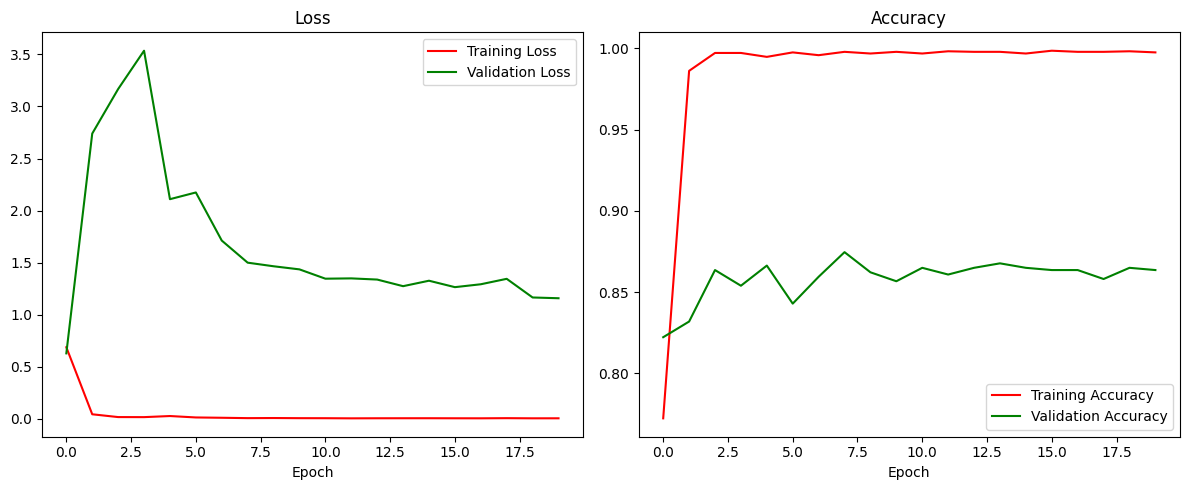

In [174]:
# Create subplots for loss and accuracy
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss', c='red')
plt.plot(val_loss, label='Validation Loss', c='green')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy', c='red')
plt.plot(val_accuracy, label='Validation Accuracy', c='green')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [106]:
# Make predictions on the validation dataset
model_4_pred_probs = lstm4.predict(test_tweet)
display(model_4_pred_probs.shape, model_4_pred_probs[:10]) # view the first 10

model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds = np.argmax(model_4_preds, axis=1)

# Calculate LSTM model results
model_4_results = calculate_results(y_true=test_sentimen,
                                    y_pred=model_4_preds)
display(model_4_results)

display(tf.squeeze(tf.round(lstm4.predict(np.array(['Pak @sandiuno dan pak @prabowo Gajinya kirim ke saya sj'])))).numpy())

23/23 [==============================] - 1s 6ms/step


(726, 3)

array([[9.9579179e-01, 6.4760371e-04, 3.5606318e-03],
       [5.0636758e-03, 3.0565557e-01, 6.8928081e-01],
       [9.9999994e-01, 1.6685554e-09, 1.5183048e-12],
       [2.7634540e-05, 9.9990231e-01, 6.9920286e-05],
       [1.9065934e-07, 9.9999315e-01, 6.5483619e-06],
       [8.6907898e-11, 9.7239415e-08, 9.9999982e-01],
       [8.2688576e-13, 9.9999994e-01, 4.2870564e-08],
       [1.5068308e-07, 9.9998277e-01, 1.7058484e-05],
       [8.8376353e-16, 9.4086535e-16, 9.9999994e-01],
       [8.1924495e-10, 9.9999994e-01, 4.5430262e-08]], dtype=float32)

{'accuracy': 86.50137741046832,
 'precision': 0.866572171963956,
 'recall': 0.8650137741046832,
 'f1': 0.8649952077269386}

1/1 [==============================] - 0s 24ms/step


array([0., 1., 0.], dtype=float32)

In [108]:
predicted_sentiment = []

for idx in range(len(test_tweet)):
  predicted = tf.squeeze(tf.round(lstm4.predict(np.array([test_tweet[idx]])))).numpy()
  predicted_sentiment.append(predicted)

1/1 [==============================] - 0s 26ms/step


In [109]:
predicted_dataframe['sentimen'] = test_sentimen
predicted_dataframe['predicted_sentimen'] = [np.argmax(array) for array in predicted_sentiment]
predicted_dataframe['tweet'] = test_tweet

display(predicted_dataframe)

,sentimen,predicted_sentimen,tweet
0,1,0,mau tanya impact buat negara kek gimana kalo g...
1,1,2,jokowi raja salman sepakat tingkat kerja sama ...
2,0,0,kala tax amnesty kemarin prabowo sama sandiaga...
3,1,1,gimana nih apa gaji tidak jokowi prabowo
4,1,1,beranganangan gaji dokter binatang minimal jut...
...,...,...,...
721,0,0,nyerocos gurubesar sumitro joyohadikusumo ekon...
722,1,1,asosiasi usaha bumiputera nusantara se indones...
723,0,0,tidak masuk otak lu bapak jokowi nanya ekonomi...
724,0,0,eh abang beda startup monetizing hobi monetize...


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['sentimen'].plot(kind='hist', bins=20, title='sentimen')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['predicted_sentimen'].plot(kind='hist', bins=20, title='predicted_sentimen')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3.plot(kind='scatter', x='index', y='sentimen', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='sentimen', y='predicted_sentimen', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['sentimen']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('sentimen')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['predicted_sentimen']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('predicted_sentimen')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_8['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['sentimen'].plot(kind='line', figsize=(8, 4), title='sentimen')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['predicted_sentimen'].plot(kind='line', figsize=(8, 4), title='predicted_sentimen')
plt.gca().spines[['top', 'right']].set_visible(False)

# Model 5

In [117]:
from keras.callbacks import EarlyStopping

In [ ]:
tf.random.set_seed(42)

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=64, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_length, # how long is each input
                             name="embedding_1")

In [153]:
def model5():

  inputs = layers.Input(shape=(1,), dtype="string")
  x = text_vectorizer(inputs)
  layer = embedding(x)
  layer = layers.LSTM(256, activation='relu', return_sequences=True)(layer)
  layer = layers.LSTM(512, activation='relu', return_sequences=True)(layer)
  layer = layers.LSTM(512, activation='relu')(layer)
  # layer = layers.Dense(512, name='FC1')(layer)
  # layer = layers.Dense(512,)(layer)
  # layer = layers.Dense(256,)(layer)
  # layer = layers.Dense(128,)(layer)
  layer = layers.Activation('relu')(layer)
  layer = layers.Dropout(0.5)(layer)
  layer = layers.Dense(3, name='out_layer')(layer)
  layer = layers.Activation('softmax')(layer)
  model = tf.keras.Model(inputs=inputs, outputs=layer)
  return model

In [154]:
lstm5 = model5()
lstm5.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
lstm5.summary()

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 19)                0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, 19, 64)            640000    
                                                                 
 lstm_35 (LSTM)              (None, 19, 256)           328704    
                                                                 
 lstm_36 (LSTM)              (None, 19, 512)           1574912   
                                                                 
 lstm_37 (LSTM)              (None, 512)               2099200   
                                                          

In [155]:
lstm5_history = lstm5.fit(X_train, np.float32(Y_train),
                          epochs=30, # 20
                          batch_size=512, # 256
                          # callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001)],
                          validation_data=(X_test, np.float32(Y_test)),)

Epoch 1/30
6/6 [==============================] - 41s 6s/step - loss: 1.0068 - accuracy: 0.6815 - val_loss: 0.6585 - val_accuracy: 0.7920
Epoch 2/30
6/6 [==============================] - 36s 6s/step - loss: 40.1350 - accuracy: 0.9032 - val_loss: 15.1117 - val_accuracy: 0.5482
Epoch 3/30
6/6 [==============================] - 39s 6s/step - loss: 2.3827 - accuracy: 0.5720 - val_loss: 1.2238 - val_accuracy: 0.5510
Epoch 4/30
6/6 [==============================] - 35s 6s/step - loss: 0.6937 - accuracy: 0.7524 - val_loss: 0.8807 - val_accuracy: 0.7369
Epoch 5/30
6/6 [==============================] - 38s 6s/step - loss: 0.7804 - accuracy: 0.9132 - val_loss: 0.8801 - val_accuracy: 0.7837
Epoch 6/30
6/6 [==============================] - 35s 6s/step - loss: 0.7231 - accuracy: 0.9318 - val_loss: 0.7387 - val_accuracy: 0.7934
Epoch 7/30
6/6 [==============================] - 37s 6s/step - loss: 0.3959 - accuracy: 0.9370 - val_loss: 1.0327 - val_accuracy: 0.7810
Epoch 8/30
6/6 [================

In [156]:
# Make predictions on the validation dataset
model_5_pred_probs = lstm5.predict(test_tweet)
display(model_5_pred_probs.shape, model_5_pred_probs[:10]) # view the first 10

model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds = np.argmax(model_5_preds, axis=1)

# Calculate LSTM model results
model_5_results = calculate_results(y_true=test_sentimen,
                                    y_pred=model_5_preds)
display(model_5_results)

display(tf.squeeze(tf.round(lstm5.predict(np.array(['Pak @sandiuno dan pak @prabowo Gajinya kirim ke saya sj'])))).numpy())

23/23 [==============================] - 4s 157ms/step


(726, 3)

array([[2.1236035e-07, 9.9999660e-01, 3.1210263e-06],
       [3.9837141e-02, 6.9663179e-01, 2.6353100e-01],
       [9.9987745e-01, 1.0630654e-04, 1.6307238e-05],
       [1.3868286e-07, 9.9999958e-01, 2.4613476e-07],
       [7.6097826e-14, 9.9999994e-01, 2.2787398e-13],
       [3.9534556e-26, 0.0000000e+00, 9.9999994e-01],
       [1.6958466e-24, 9.9999994e-01, 1.7461132e-22],
       [5.9757899e-29, 9.9999994e-01, 1.5065258e-28],
       [6.7349382e-26, 0.0000000e+00, 9.9999994e-01],
       [2.4404514e-07, 9.9999946e-01, 2.0071542e-07]], dtype=float32)

{'accuracy': 84.43526170798899,
 'precision': 0.8460291721478702,
 'recall': 0.8443526170798898,
 'f1': 0.8446113831614406}

1/1 [==============================] - 0s 53ms/step


array([0., 1., 0.], dtype=float32)

In [157]:
predicted_sentiment = []

for idx in range(len(test_tweet)):
  predicted = tf.squeeze(tf.round(lstm5.predict(np.array([test_tweet[idx]])))).numpy()
  predicted_sentiment.append(predicted)

1/1 [==============================] - 0s 70ms/step


In [158]:
predicted_dataframe['sentimen'] = test_sentimen
predicted_dataframe['predicted_sentimen'] = [np.argmax(array) for array in predicted_sentiment]
predicted_dataframe['tweet'] = test_tweet

display(predicted_dataframe)

,sentimen,predicted_sentimen,tweet
0,1,1,mau tanya impact buat negara kek gimana kalo g...
1,1,1,jokowi raja salman sepakat tingkat kerja sama ...
2,0,0,kala tax amnesty kemarin prabowo sama sandiaga...
3,1,1,gimana nih apa gaji tidak jokowi prabowo
4,1,1,beranganangan gaji dokter binatang minimal jut...
...,...,...,...
721,0,0,nyerocos gurubesar sumitro joyohadikusumo ekon...
722,1,1,asosiasi usaha bumiputera nusantara se indones...
723,0,0,tidak masuk otak lu bapak jokowi nanya ekonomi...
724,0,0,eh abang beda startup monetizing hobi monetize...


# Random Forest

In [159]:
rfc = RandomForestClassifier()

In [161]:
X_vect = text_vectorizer(X_train)
X_embedd = embedding(X_vect)

In [163]:
rfc.fit(X_vect, np.float32(Y_train))

RandomForestClassifier()

In [165]:
XT_vect = text_vectorizer(X_test)
rfc_score = rfc.score(XT_vect, np.float32(Y_test))
print(rfc_score)

0.8636363636363636


In [166]:
from sklearn.metrics import classification_report

In [167]:
y_pred = rfc.predict(XT_vect)
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.87      0.87       242
           1       0.87      0.87      0.87       256
           2       0.84      0.85      0.84       228

    accuracy                           0.86       726
   macro avg       0.86      0.86      0.86       726
weighted avg       0.86      0.86      0.86       726

